In [51]:
# from wwo_hist import retrieve_hist_data
import pandas as pd
import seaborn as sns
from datetime import datetime
import math
from datetime import timedelta
from sklearn import metrics
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import numpy as np
from xgboost import XGBClassifier
import pickle

In [2]:
# frequency = 3
# start_date = '01-JAN-2009'
# end_date = '31-DEC-2021'
# api_key = '06199218b89440389fc112619220501'
# location = ['Pithoragarh']

# hist_weather_data = retrieve_hist_data(api_key,
#                                       location,
#                                       start_date,
#                                       end_date,
#                                       frequency,
#                                       location_label= False,
#                                       export_csv= True,
#                                       store_df = True)

In [3]:
weather_df = pd.read_csv("Pithoragarh.csv")
weather_df.head(5)

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2009-01-01 00:00:00,19,4,0.0,8.7,4,32,09:59 AM,09:44 PM,07:04 AM,...,27,0,26,0.0,1018,4,10,23,13,Pithoragarh
1,2009-01-01 03:00:00,19,4,0.0,8.7,4,32,09:59 AM,09:44 PM,07:04 AM,...,33,0,24,0.0,1019,8,10,25,16,Pithoragarh
2,2009-01-01 06:00:00,19,4,0.0,8.7,4,32,09:59 AM,09:44 PM,07:04 AM,...,21,0,21,0.0,1019,12,10,35,12,Pithoragarh
3,2009-01-01 09:00:00,19,4,0.0,8.7,4,32,09:59 AM,09:44 PM,07:04 AM,...,12,0,15,0.0,1016,19,10,204,11,Pithoragarh
4,2009-01-01 12:00:00,19,4,0.0,8.7,4,32,09:59 AM,09:44 PM,07:04 AM,...,14,0,17,0.0,1015,19,10,226,12,Pithoragarh


In [4]:
weather_df.isnull().sum()

date_time            0
maxtempC             0
mintempC             0
totalSnow_cm         0
sunHour              0
uvIndex              0
moon_illumination    0
moonrise             0
moonset              0
sunrise              0
sunset               0
DewPointC            0
FeelsLikeC           0
HeatIndexC           0
WindChillC           0
WindGustKmph         0
cloudcover           0
humidity             0
precipMM             0
pressure             0
tempC                0
visibility           0
winddirDegree        0
windspeedKmph        0
location             0
dtype: int64

In [5]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37984 entries, 0 to 37983
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date_time          37984 non-null  object 
 1   maxtempC           37984 non-null  int64  
 2   mintempC           37984 non-null  int64  
 3   totalSnow_cm       37984 non-null  float64
 4   sunHour            37984 non-null  float64
 5   uvIndex            37984 non-null  int64  
 6   moon_illumination  37984 non-null  int64  
 7   moonrise           37984 non-null  object 
 8   moonset            37984 non-null  object 
 9   sunrise            37984 non-null  object 
 10  sunset             37984 non-null  object 
 11  DewPointC          37984 non-null  int64  
 12  FeelsLikeC         37984 non-null  int64  
 13  HeatIndexC         37984 non-null  int64  
 14  WindChillC         37984 non-null  int64  
 15  WindGustKmph       37984 non-null  int64  
 16  cloudcover         379

In [6]:
weather_df["moonrise"] = weather_df["moonrise"].replace({"No moonrise":math.nan})
weather_df["moonset"] = weather_df["moonset"].replace({"No moonset":math.nan})
weather_df["sunrise"] = weather_df["sunrise"].replace({"No sunrise":math.nan})
weather_df["sunset"] = weather_df["sunset"].replace({"No sunset":math.nan})

weather_df["moonrise"] = weather_df["moonrise"].fillna(weather_df["moonrise"].mode()[0])
weather_df["moonset"] = weather_df["moonset"].fillna(weather_df["moonset"].mode()[0])
weather_df["sunrise"] = weather_df["sunrise"].fillna(weather_df["sunrise"].mode()[0])
weather_df["sunset"] = weather_df["sunset"].fillna(weather_df["sunset"].mode()[0])

In [7]:
weather_df["moonrise"] = pd.to_datetime(weather_df["moonrise"], format='%I:%M %p')
weather_df["moonset"] = pd.to_datetime(weather_df["moonset"], format='%I:%M %p')
weather_df["sunrise"] = pd.to_datetime(weather_df["sunrise"], format='%I:%M %p')
weather_df["sunset"] = pd.to_datetime(weather_df["sunset"], format='%I:%M %p')

In [8]:
weather_df["nightHours"] = (weather_df["moonset"] - weather_df["moonrise"])/timedelta(hours =1)
weather_df["dayHours"] = (weather_df["sunset"] - weather_df["sunrise"])/timedelta(hours =1)

In [9]:
weather_df["snowfall"] = weather_df["totalSnow_cm"].map(lambda x:1 if (x > 0.0) else 0)

In [10]:
clean_df = weather_df.drop(columns=["moonrise", "moonset", "sunrise", "sunset", "location", "date_time", "totalSnow_cm"])
clean_df.head(15)

,maxtempC,mintempC,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,...,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,nightHours,dayHours,snowfall
0,19,4,8.7,4,32,-13,1,4,1,27,...,26,0.0,1018,4,10,23,13,11.750000,10.3,0
1,19,4,8.7,4,32,-11,6,8,6,33,...,24,0.0,1019,8,10,25,16,11.750000,10.3,0
2,19,4,8.7,4,32,-10,11,12,11,21,...,21,0.0,1019,12,10,35,12,11.750000,10.3,0
3,19,4,8.7,4,32,-8,19,19,19,12,...,15,0.0,1016,19,10,204,11,11.750000,10.3,0
4,19,4,8.7,4,32,-7,19,19,19,14,...,17,0.0,1015,19,10,226,12,11.750000,10.3,0
5,19,4,8.7,4,32,0,8,9,8,17,...,54,0.0,1017,9,10,215,8,11.750000,10.3,0
6,19,4,8.7,4,32,-9,2,4,2,20,...,39,0.0,1019,4,10,34,9,11.750000,10.3,0
7,19,4,8.7,4,32,-11,2,5,2,26,...,30,0.0,1020,5,10,24,12,11.750000,10.3,0
8,19,4,8.7,4,39,-14,1,4,1,26,...,25,0.0,1020,4,10,27,13,12.183333,10.3,0
9,19,4,8.7,4,39,-12,6,8,6,19,...,22,0.0,1020,8,10,51,9,12.183333,10.3,0


<AxesSubplot:>

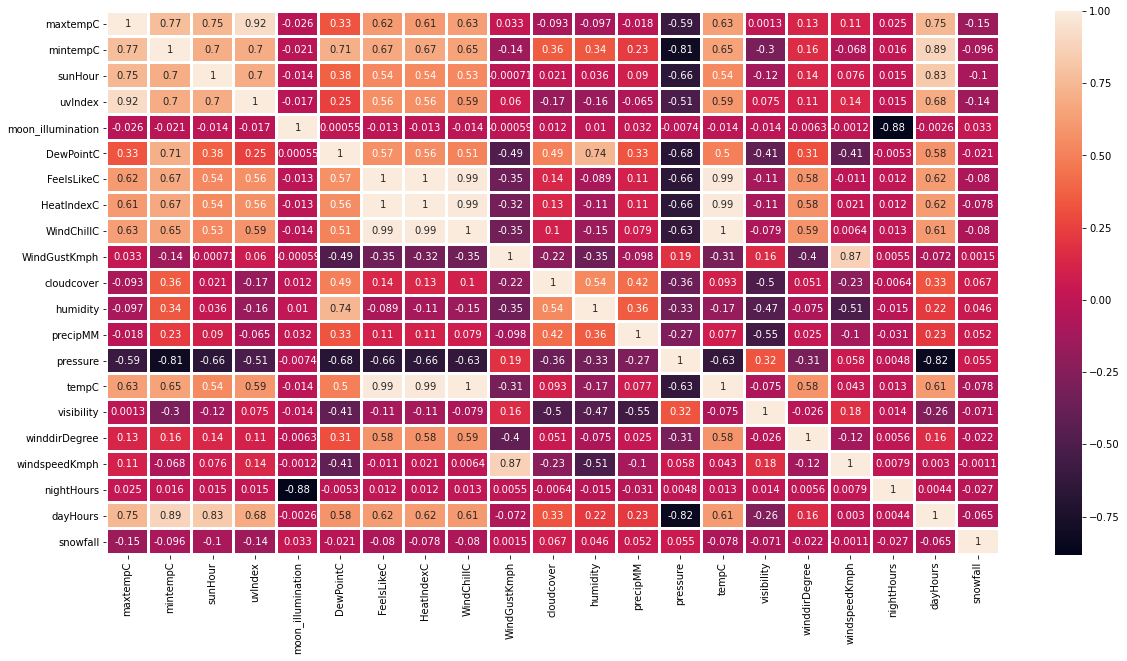

In [11]:
corr = clean_df.corr()
plt.figure(figsize= (20,10))
sns.heatmap(corr, 
            xticklabels=corr.columns, yticklabels=corr.columns, linewidths=2, annot=True)

In [12]:
cleanDf = clean_df.drop(columns=["dayHours", "pressure", "uvIndex", "DewPointC", "mintempC", "WindGustKmph", "tempC", "WindChillC", "HeatIndexC", "moon_illumination", "sunHour"])

<AxesSubplot:>

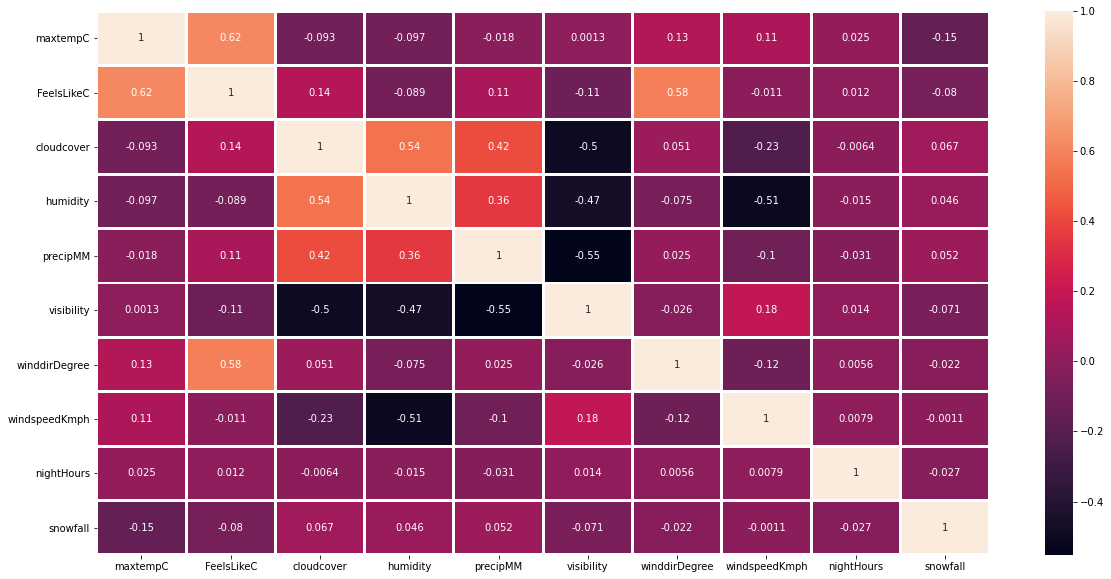

In [13]:
corr = cleanDf.corr()
plt.figure(figsize= (20,10))
sns.heatmap(corr, 
            xticklabels=corr.columns, yticklabels=corr.columns, linewidths=2, annot=True)

In [14]:
#data sacaling (normalizing)
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
#     df["pressure"] = min_max_scaler.fit_transform(df["pressure"].values.reshape(-1,1))
    df["winddirDegree"] = min_max_scaler.fit_transform(df["winddirDegree"].values.reshape(-1,1))
    return df
normalize_data(cleanDf)

,maxtempC,FeelsLikeC,cloudcover,humidity,precipMM,visibility,winddirDegree,windspeedKmph,nightHours,snowfall
0,19,1,0,26,0.0,10,0.063889,13,11.750000,0
1,19,6,0,24,0.0,10,0.069444,16,11.750000,0
2,19,11,0,21,0.0,10,0.097222,12,11.750000,0
3,19,19,0,15,0.0,10,0.566667,11,11.750000,0
4,19,19,0,17,0.0,10,0.627778,12,11.750000,0
...,...,...,...,...,...,...,...,...,...,...
37979,16,11,44,44,0.0,10,0.075000,4,10.733333,0
37980,16,16,27,31,0.0,10,0.663889,4,10.733333,0
37981,16,15,21,37,0.0,10,0.633333,6,10.733333,0
37982,16,8,8,75,0.0,10,0.338889,2,10.733333,0


In [15]:
X = cleanDf.drop(columns = ['snowfall']).copy()
y = cleanDf['snowfall']
print(X.shape)
print(y.shape)

(37984, 9)
(37984,)


In [21]:
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7, random_state = 100, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state = 100, stratify=y_rem)
print(X_train.shape), print(y_train.shape)
print(X_rem.shape), print(y_rem.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(26588, 9)
(26588,)
(11396, 9)
(11396,)
(5698, 9)
(5698,)
(5698, 9)
(5698,)


(None, None)

In [17]:
#Finding best hyperparameters using GridSearchCV
#This will take alot of time in low end PC.
# import warnings
# warnings.filterwarnings('ignore')
# xgboost = XGBClassifier()

# booster = ["gbtree", "gblinear", "dart"]
# eta = np.arange(0.0, 1.1, 0.1)
# gamma = np.arange(0, 11, 1)
# maxDepth = np.arange(0, 11, 1)
# samplingMethod = ["uniform", "gradient_based"]
# treeMethod = ["auto", "exact", "approx", "hist", "gpu_hist"]

# grid={
#     "booster": booster,
#     "learning_rate": eta,
#     "gamma":gamma,
#     "max_depth": maxDepth,
#     "sampling_method":samplingMethod,
#     "tree_method":treeMethod
#      }
# clf = GridSearchCV(xgboost, grid,cv=10)
# clf.fit(X_train, y_train)

In [ ]:
# print("tuned hpyerparameters :(best parameters) ",clf.best_params_)
# print("accuracy :",clf.best_score_)

In [23]:
valid_fpr, valid_tpr, valid_thresholds = metrics.roc_curve(y_test, y_test_pred)

No handles with labels found to put in legend.


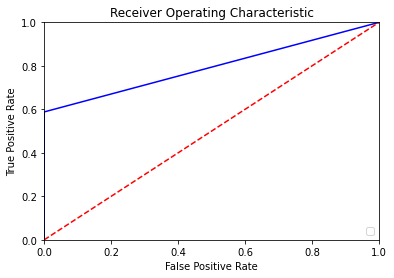

In [24]:
plt.title('Receiver Operating Characteristic')
plt.plot(valid_fpr, valid_tpr, 'b')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [28]:
import warnings
warnings.filterwarnings('ignore')
xgboost = XGBClassifier()
grid={
    "learning_rate": [0.01, 0.1, 0.5, 1, 10],
    "gamma":[0.01, 0.1,10],
    "max_depth": [1, 3, 5,10,15]
}
clf = GridSearchCV(xgboost, grid,cv=10)
clf.fit(X_train, y_train)

[08:22:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:22:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:22:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:22:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:22:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:22:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:22:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:22:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:23:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:23:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:23:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:23:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:23:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:23:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:23:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:23:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:23:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:23:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:23:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:23:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:24:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:24:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:24:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:24:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:24:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:24:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:24:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:24:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:24:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:24:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:24:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:24:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:24:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:24:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:24:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:24:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:25:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:25:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:25:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:25:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:25:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:25:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:25:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:25:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:25:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:25:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:25:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:25:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:26:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:26:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:26:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:26:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:26:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:26:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:26:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:26:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:26:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:26:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:26:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:26:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:26:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:26:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:26:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:26:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:26:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:26:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:26:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:26:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:27:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:27:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:27:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:27:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:27:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:27:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:27:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:27:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:28:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:28:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:28:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:28:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:28:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:28:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:28:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:28:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:28:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:28:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:29:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:29:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[08:29:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:29:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:29:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:29:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weigh

In [29]:
print("tuned hpyerparameters :(best parameters) ",clf.best_params_)
print("accuracy :",clf.best_score_)

tuned hpyerparameters :(best parameters)  {'gamma': 0.01, 'learning_rate': 0.5, 'max_depth': 3}
accuracy : 0.9987588470351133


In [32]:
model = XGBClassifier(gamma= 0.01, learning_rate= 0.5, max_depth=3)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

[08:31:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [33]:
y_train_pred = model.predict(X_train)

In [34]:
train_confusion = metrics.confusion_matrix(y_train, y_train_pred)
train_TP = train_confusion[1, 1]
train_TN = train_confusion[0, 0]
train_FP = train_confusion[0, 1]
train_FN = train_confusion[1, 0]
print(train_confusion)

[[26510     0]
 [    0    78]]


In [35]:
test_confusion = metrics.confusion_matrix(y_test, y_test_pred)
test_TP = test_confusion[1, 1]
test_TN = test_confusion[0, 0]
test_FP = test_confusion[0, 1]
test_FN = test_confusion[1, 0]
print(test_confusion)

[[5680    1]
 [   7   10]]


In [36]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5681
           1       0.91      0.59      0.71        17

    accuracy                           1.00      5698
   macro avg       0.95      0.79      0.86      5698
weighted avg       1.00      1.00      1.00      5698



In [37]:
print("Accuracy:")
print(metrics.accuracy_score(y_test, y_test_pred))
print("ROC AUC Score:")
print(metrics.roc_auc_score(y_test, y_test_pred))

Accuracy:
0.9985959985959986
ROC AUC Score:
0.7940296343849986


In [47]:
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(y_test, y_test_pred)

No handles with labels found to put in legend.


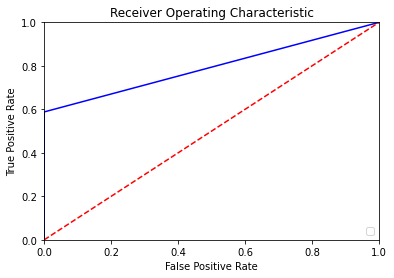

In [40]:
plt.title('Receiver Operating Characteristic')
plt.plot(test_fpr, test_tpr, 'b')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [41]:
y_valid_pred = model.predict(X_valid)

In [42]:
test_confusion = metrics.confusion_matrix(y_valid, y_valid_pred)
test_TP = test_confusion[1, 1]
test_TN = test_confusion[0, 0]
test_FP = test_confusion[0, 1]
test_FN = test_confusion[1, 0]
print(test_confusion)

[[5679    2]
 [   6   11]]


In [43]:
print(classification_report(y_valid,y_valid_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5681
           1       0.85      0.65      0.73        17

    accuracy                           1.00      5698
   macro avg       0.92      0.82      0.87      5698
weighted avg       1.00      1.00      1.00      5698



In [45]:
print("Accuracy:")
print(metrics.accuracy_score(y_valid, y_valid_pred))
print("ROC AUC Score:")
print(metrics.roc_auc_score(y_valid, y_valid_pred))

Accuracy:
0.9985959985959986
ROC AUC Score:
0.8233533864170559


In [48]:
valid_fpr, valid_tpr, valid_thresholds = metrics.roc_curve(y_valid, y_valid_pred)

No handles with labels found to put in legend.


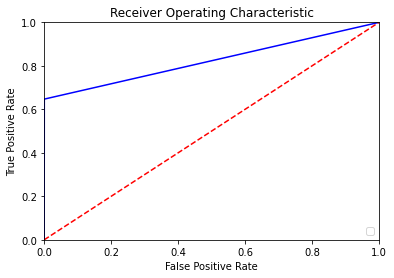

In [49]:
plt.title('Receiver Operating Characteristic')
plt.plot(valid_fpr, valid_tpr, 'b')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [52]:
# save the model to disk
filename = 'xgboost.pkl'
pickle.dump(model, open(filename, 'wb'))

In [53]:
cleanDf.columns

Index(['maxtempC', 'FeelsLikeC', 'cloudcover', 'humidity', 'precipMM',
       'visibility', 'winddirDegree', 'windspeedKmph', 'nightHours',
       'snowfall'],
      dtype='object')

In [54]:
file = open("columns_required.txt", "w")
file.write(str(cleanDf.columns.values))
file.close()